In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 

from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten 
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.metrics import Mean



# Sample Data 

X = np.random.random((8, 3))
y =  X* 3 + 1 + np.random.random((8, 3)); print(X); print(y)

[[0.66841712 0.503587   0.17054433]
 [0.05277568 0.99959832 0.77398044]
 [0.58961607 0.12500656 0.75058124]
 [0.87611853 0.38584456 0.24875073]
 [0.39744152 0.32859573 0.7398945 ]
 [0.75035931 0.46256309 0.27387203]
 [0.65039726 0.68825647 0.79373498]
 [0.87483158 0.893202   0.16285258]]
[[3.74217232 2.6637829  2.44783474]
 [1.66109465 4.46410103 3.92756066]
 [2.96521143 1.65937561 3.42279774]
 [3.72508342 2.79271255 1.75198962]
 [3.00247765 2.53055461 3.41902224]
 [4.13822344 2.45275675 2.01464591]
 [3.42650696 3.51527633 3.49945878]
 [4.47786493 4.41642133 2.17996706]]


각 데이터는 block의 단위로 수집됨

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


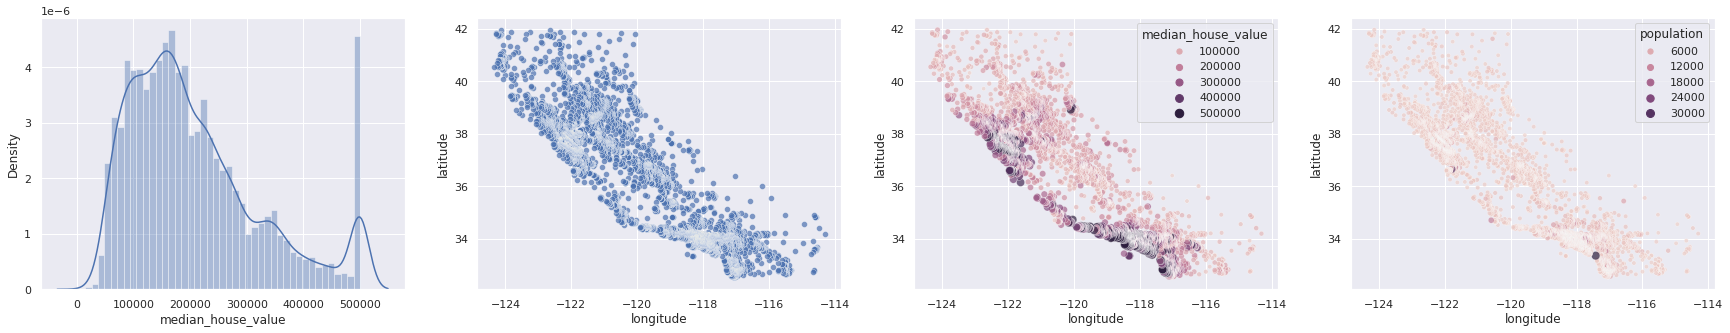

In [ ]:
df = pd.read_csv("/content/sample_data/california_housing_train.csv")
df_test = pd.read_csv("/content/sample_data/california_housing_test.csv")

df.head()
fig, axes = plt.subplots(1, 4, figsize=(30,5))

sns.distplot(df['median_house_value'], ax=axes[0])
sns.scatterplot(x='longitude',y='latitude', data=df, alpha = 0.7, ax = axes[1])
sns.scatterplot(x='longitude',y='latitude', data=df, alpha = 0.7, ax = axes[2], hue = df["median_house_value"], size = df["median_house_value"])
sns.scatterplot(x='longitude',y='latitude', data=df, alpha = 0.7, ax = axes[3], hue = df["population"], size = df["population"])

### Scaling longitude and latitude

In [ ]:
scaler = MinMaxScaler()

# fit and transfrom
df[['longitude', 'latitude']] = scaler.fit_transform(df[['longitude', 'latitude']])
df_test[['longitude', 'latitude']] = scaler.fit_transform(df_test[['longitude', 'latitude']])


# everything has been scaled between 1 and 0
print('Max: ',df["longitude"].max())
print('Min: ', df["longitude"].min())

df.describe()

y = df["median_house_value"]
X = df.drop(["median_house_value"], axis = 1); 
y_test = df_test["median_house_value"]
X_test = df_test.drop(["median_house_value"], axis = 1); X_test.head()

Max:  1.0
Min:  0.0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.219814,0.513889,27.0,3885.0,661.0,1537.0,606.0,6.6085
1,0.606811,0.181624,43.0,1510.0,310.0,809.0,277.0,3.5990
2,0.657379,0.130342,27.0,3589.0,507.0,1484.0,495.0,5.7934
3,0.600619,0.134615,28.0,67.0,15.0,49.0,11.0,6.1359
4,0.465428,0.402778,19.0,1241.0,244.0,850.0,237.0,2.9375


In [ ]:
class My_Model(tf.keras.Model):
    def __init__(self):
        super(My_Model, self).__init__()
        
        
        self.d1 = Dense(32,activation='relu')
        self.drop1 = Dropout(0.5)
        self.d2 = Dense(64,activation='relu')
        self.drop2 = Dropout(0.5)
        self.d3 = Dense(32,activation='relu')
        self.drop3 = Dropout(0.5)
        self.d4 = Dense(8,activation='relu')

        self.d5 = Dense(1,activation='relu')
        
    # init에서 만든 layer를 불러와서 network 구성( 연산 파트 )
    def call(self, x):
        x = self.d1(x)
        x = self.drop1(x)
        x = self.d2(x)
        x = self.drop2(x)
        x = self.d3(x)
        x = self.drop3(x)
        x = self.d4(x)
        x = self.d5(x)

        return x

In [ ]:
keras.backend.clear_session()

model = My_Model() # model 클래스를 model 객체로 변경
# temp_inputs = keras.Input(shape=(-1, 1)) # model input image size
# model(temp_inputs) # model input
# model.summary() # 모델에 대한 요약 출력해줌

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x=X, y=y.values, batch_size=128, epochs=100, validation_data=(X_test,y_test.values))

#### partial함수를 이용해 반복되는 매개변수를 줄여 은닉층 구성
#### Dropout을 많이 넣으니 학습속도가 상당히 느려진다

In [ ]:
from functools import partial

RegularizedDense = partial(Dense,
                  activation = "relu",
                  kernel_initializer = "he_normal",
                  kernel_regularizer = keras.regularizers.l2(0.01))

model = Sequential()
model.add(RegularizedDense(32))
model.add(Dropout(0.5))
model.add(RegularizedDense(64))
model.add(Dropout(0.5))
model.add(RegularizedDense(32))
model.add(Dropout(0.5))
model.add(RegularizedDense(8))
model.add(Dense(1, activation = "relu"))

In [ ]:
keras.backend.clear_session()
model.compile(loss = "mse", optimizer = "adam")
model.fit(x=X, y=y.values, batch_size=32, epochs=100, validation_data=(X_test,y_test.values), callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

Epoch 1/100
532/532 [==============================] - 2s 3ms/step - loss: 30321721344.0000 - val_loss: 28802164736.0000
Epoch 2/100
532/532 [==============================] - 2s 3ms/step - loss: 29430876160.0000 - val_loss: 26664667136.0000
Epoch 3/100
532/532 [==============================] - 2s 3ms/step - loss: 29182627840.0000 - val_loss: 27725918208.0000
Epoch 4/100
532/532 [==============================] - 2s 3ms/step - loss: 27912263680.0000 - val_loss: 25047066624.0000
Epoch 5/100
532/532 [==============================] - 2s 3ms/step - loss: 26762682368.0000 - val_loss: 24669122560.0000
Epoch 6/100
532/532 [==============================] - 2s 3ms/step - loss: 25853618176.0000 - val_loss: 22930124800.0000
Epoch 7/100
532/532 [==============================] - 2s 4ms/step - loss: 22829174784.0000 - val_loss: 17340235776.0000
Epoch 8/100
532/532 [==============================] - 2s 3ms/step - loss: 20279687168.0000 - val_loss: 15994286080.0000
Epoch 9/100
532/532 [===========

#### Random Search를 사용하기 위해 모델을 만드는 함수 생성

In [ ]:
def build_regressor(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3, input_shape = [8]):
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))

  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation = "relu"))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.Adam(lr = learning_rate)
  model.compile(loss = "mse", optimizer = optimizer)

  return model

In [ ]:
keras_reg = KerasRegressor(build_regressor)

param_distribs = {
    "n_hidden": [3, 2, 1],
    "n_neurons": [8, 16, 32, 64, 256], 
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter = 10, cv = 3)
rnd_search_cv.fit(X, y.values, epochs = 100, validation_data=(X_test,y_test.values), callbacks = [keras.callbacks.EarlyStopping(patience = 10)])

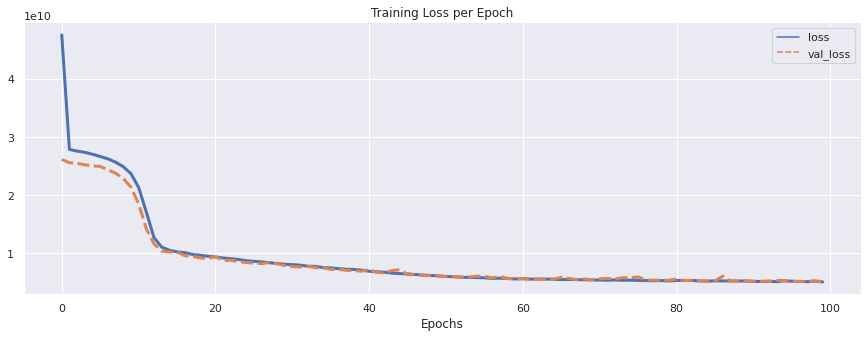

In [ ]:
losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()

## Mnist Start

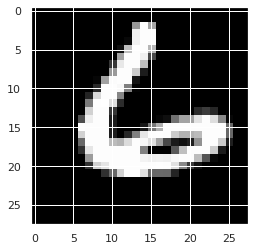

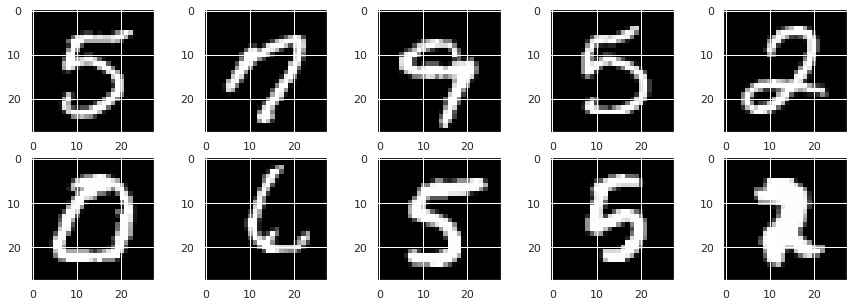

In [ ]:
mnist = pd.read_csv("/content/sample_data/mnist_train_small.csv")
mnist_test = pd.read_csv("/content/sample_data/mnist_test.csv")

mnist.rename(columns = {'6' : 'label'}, inplace = True)
mnist_test.rename(columns = {'7' : 'label'}, inplace = True)
y_mnist = mnist.label
y_mnist_test = mnist_test.label


mnist.drop(["label"], axis = 1, inplace = True)
mnist_test.drop(["label"], axis = 1, inplace = True)

mnist = np.array(mnist).reshape(19999, 28, 28, 1)
mnist_test = np.array(mnist_test).reshape(9999, 28, 28, 1)


mnist_idx = 100
image = mnist[100, ]

'''for index, pixel in enumerate(image):
  print("%10f" %pixel, end = '')
  if index %28 == 0:
    print("")'''

image = mnist[100,]
image = np.array(image).reshape([28, 28])

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

fig, ax = plt.subplots(2, 5, figsize=(15, 5))

for i, ax in enumerate(ax.flatten()):
  image = mnist[i,]
  image = image.reshape([28, 28])    

  ax.imshow(image, cmap='gray')



### CNN 구성하기

In [ ]:
class MyCNN(tf.keras.Model):
    def __init__(self):
        super(MyCNN, self).__init__()

        self.d1 = Sequential()
        self.d2 = Conv2D(32, (3, 3), input_shape = (28, 28, 1), activation = "relu")
        self.d3 = MaxPooling2D(pool_size = (2, 2))
        self.d4 = Conv2D(32, (3, 3), activation = "relu")
        self.d5 = MaxPooling2D(pool_size = (2, 2))
        self.d6 = Flatten()
        self.d7 = Dense(units = 96, activation = "relu")
        self.d8 = Dropout(.5)
        self.d9 = Dense(units=32, activation='relu')
        self.d10 = Dense(units=10, activation='softmax')

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        x = self.d6(x)
        x = self.d7(x)
        x = self.d8(x)
        x = self.d9(x)
        x = self.d10(x)

        return x

In [ ]:
np.array(mnist)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
sz = 28

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (sz, sz, 1), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=96, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

model.summary()

model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
history = model.fit(mnist, y = y_mnist, epochs = 100, validation_data=(mnist_test, y_mnist_test), callbacks = [keras.callbacks.EarlyStopping(patience = 10)])